In [1]:
case_study_dir = "/Users/ryuto/lab/research/work/ACL2020/Args_PRED_IN_S_NOT_DEP_ALL"

In [2]:
import re

def extract_case_study(file):
    with open(file) as fi:
        result = []
        for line in fi:
            if re.match(r"(.*?)ntc", line):
                file_name, sent_id, prd_id, *_, case = line.rstrip("\n").split()
                result.append((file_name, int(sent_id), int(prd_id), case))
    return result

In [3]:
np = case_study_dir + "/np.txt"
pn = case_study_dir + "/pn.txt"
train = "/Users/ryuto/lab/research/work/ACL2020/train.jsonl"
dev = "/Users/ryuto/lab/research/work/ACL2020/dev.jsonl"

In [4]:
case_study = list(set(extract_case_study(np) + extract_case_study(pn)))

In [5]:
case_study[:10]

[('9509ED-0048-950929044.ntc', 12, 5, 'ga'),
 ('950112-0200-950112282.ntc', 4, 7, 'o'),
 ('950113-0010-950113013.ntc', 0, 68, 'ga'),
 ('950112-0094-950112122.ntc', 5, 5, 'ga'),
 ('950113-0152-950113219.ntc', 3, 27, 'ga'),
 ('950112-0119-950112169.ntc', 1, 5, 'ga'),
 ('950112-0207-950112297.ntc', 1, 18, 'ga'),
 ('9509ED-0013-950909045.ntc', 26, 27, 'o'),
 ('950113-0017-950113021.ntc', 4, 30, 'o'),
 ('9509ED-0013-950909045.ntc', 9, 22, 'ga')]

In [6]:
import json

with open(train) as fi:
    train_instances = [json.loads(line) for line in fi]
with open(dev) as fi:
    dev_instances = [json.loads(line) for line in fi]

In [7]:
from os import path

def extract_pc(instance, p_id, case):
    converter = {"ga": 0, "o": 1, "ni": 2}
    for pas in instance["pas"]:
        if pas["p_id"] == p_id:
            c_id, c_base, c_type = None, None, None
            
            if converter[case] in pas["args"]:
                c_id = pas["args"].index(converter[case])
                c_base = instance["bases"][c_id]
                c_type = pas["types"][c_id]
                
            p_base = instance["bases"][p_id]
            
            return  c_id, c_base, c_type, p_base

not_corrects = []

for cs in case_study:
    for instance in dev_instances:
        file_name, sent_id, p_id, case = cs
        if path.basename(instance["file name"]) == file_name and instance["sentence id"] == sent_id:
            c_id, c_base, c_type, p_base = extract_pc(instance, p_id, case)
            not_corrects.append((c_id, c_base, c_type, case, p_id, p_base, instance["bases"]))
            break

In [8]:
print(len(not_corrects))
not_corrects[0]

2456


(1,
 '知事',
 'zero',
 'ga',
 5,
 '基づく',
 ['青島', '知事', 'は', '公約', 'に', '基づく', '世界', '都市', '博', '中止', 'に', '踏み切る', '。'])

In [9]:
train_prd = set(instance["bases"][pas["p_id"]] for instance in train_instances for pas in instance["pas"])
dev_prd = set(instance["bases"][pas["p_id"]] for instance in dev_instances for pas in instance["pas"])
not_corrects_prd = set(prd for *_, prd, _ in not_corrects)
print(len(train_prd), len(dev_prd), len(not_corrects_prd), len(train_prd & dev_prd), len(not_corrects_prd & train_prd))

6370 2663 827 2043 710


In [10]:
from collections import Counter

train_prd_count = Counter(instance["bases"][pas["p_id"]] for instance in train_instances for pas in instance["pas"])

In [10]:
from collections import Counter
dev = Counter(len(instance["bases"]) for instance in dev_instances for pas in instance["pas"])
nc = Counter(len(bases) for *_, bases in not_corrects)

In [12]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
max_len = max(dev + nc)
df = pd.DataFrame({"dev_DEP": [dev[i] if i in dev else 0 for i in range(max_len + 1)], 
                   "dev_not_correct": [nc[i] if i in nc else 0 for i in range(max_len + 1)]})

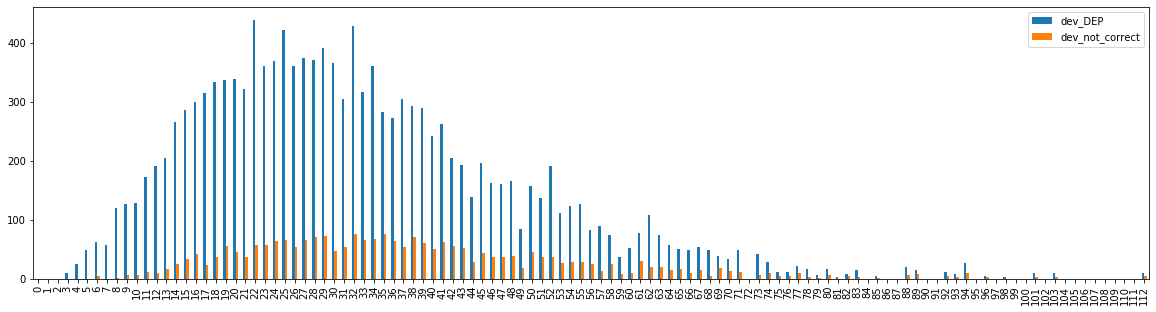

In [13]:
df.plot(kind="bar", figsize=(20, 5))

In [14]:
def length_between_cp(instances, c_type):
    lens = []
    for instance in instances:
        lens += [abs(pas["args"].index(case) - pas["p_id"]) for pas in instance["pas"] for case in [0, 1, 2] if case in pas["args"] and c_type == pas["types"][pas["args"].index(case)]]
    return Counter(lens)


dep_dev = length_between_cp(dev_instances, "dep")
zero_dev = length_between_cp(dev_instances, "zero")
dep_nc = Counter(abs(c_id - p_id) for c_id, _, c_type, _, p_id, p_base, _ in not_corrects if c_id is not None and c_type == "dep")
zero_nc = Counter(abs(c_id - p_id) for c_id, _, c_type, _, p_id, p_base, _ in not_corrects if c_id is not None and c_type == "zero")

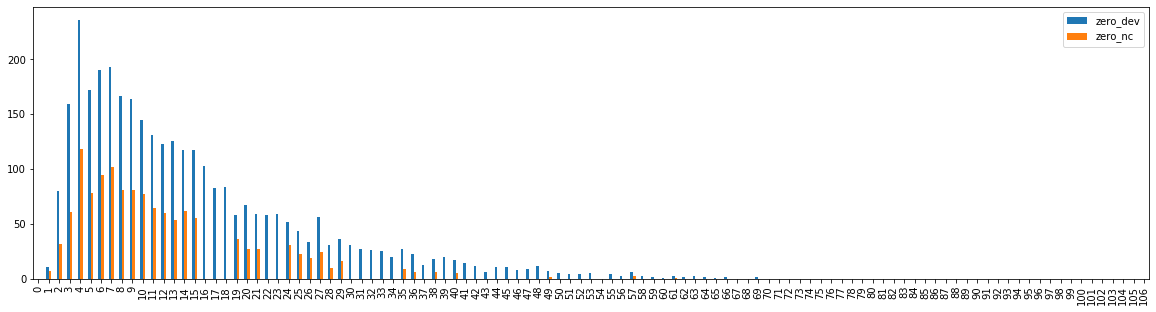

In [15]:
max_len = max(dep_dev + dep_nc)
df = pd.DataFrame({"zero_dev": [zero_dev[i] if i in dep_dev else 0 for i in range(max_len + 1)], 
                   "zero_nc": [zero_nc[i] if i in dep_nc else 0 for i in range(max_len + 1)]})
df.plot(kind="bar", figsize=(20, 5))

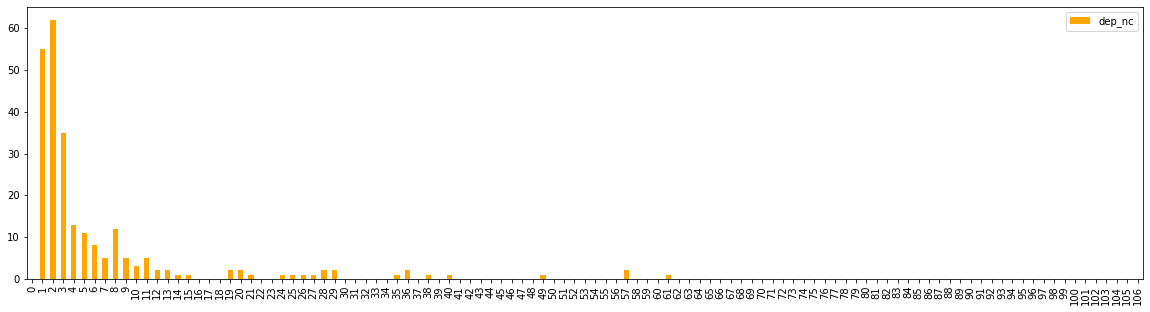

In [16]:
max_len = max(dep_dev + dep_nc)
df = pd.DataFrame({"dep_nc": [dep_nc[i] if i in dep_nc else 0 for i in range(max_len + 1)]})
df.plot(kind="bar", figsize=(20, 5), color="orange")

In [17]:
def get_cp(instances, c_type):
    cps = []
    for instance in instances:
        cps += [(instance["bases"][pas["args"].index(case)], instance["bases"][pas["p_id"]]) 
                for pas in instance["pas"] for case in [0, 1, 2] 
                if case in pas["args"] and pas["types"][pas["args"].index(case)] == c_type]
    return Counter(cps)

dep_train = get_cp(train_instances, "dep")
dep_dev = get_cp(dev_instances, "dep")
dep_nc = Counter((c_base, p_base) for _, c_base, c_type, _, _, p_base, _ in not_corrects if c_base is not None and c_type == "dep")

zero_train = get_cp(train_instances, "zero")
zero_dev = get_cp(dev_instances, "zero")
zero_nc = Counter((c_base, p_base) for _, c_base, c_type, _, _, p_base, _ in not_corrects if c_base is not None and c_type == "zero")

In [24]:
print("dep: dev = {}".format(len(dep_dev)))
print("dep: trainに未出現のdevのpair数 = {}".format(len(dep_dev) - len(dep_dev & dep_train)))
print()
print("zero: dev = {}".format(len(zero_dev)))
print("zero: trainに未出現のdevのpair数 = {}".format(len(zero_dev) - len(zero_dev & zero_train)))
print()
print("dep: 解けないpair = {}".format(len(dep_nc)))
print("dep: 解けない & trainに未出現な pair数 = {}".format(len(dep_nc) - len(dep_train & dep_nc)))
print()
print("zero: 解けないpair = {}".format(len(zero_nc)))
print("zero: 解けない & trainに未出現な pair数 = {}".format(len(zero_nc) - len(zero_train & zero_nc)))

dep: dev = 10572
dep: trainに未出現のdevのpair数 = 7107

zero: dev = 2683
zero: trainに未出現のdevのpair数 = 2122

dep: 解けないpair = 237
dep: 解けない & trainに未出現な pair数 = 151

zero: 解けないpair = 1377
zero: 解けない & trainに未出現な pair数 = 1092


In [164]:
print(len(c30), len(c31), len(c30 & c31), len(c32), len(c30 & c32))

50235 12707 4107 1591 522
